## Aplicação de pré-processamento em sinais de EMG (Eletromiografia)
### UTFPR — Universidade Tecnológica Federal do Paraná
#### Nomes: Rafael Menezes Barboza, Carlos Alexandre Peron dos Santos

#### Explicação das bases de dados:
Cada conjunto de dados foi gerado por meio do OpenBCI Ganglion Board, com taxa de amostragem de 200 Hz, utilizando 4 eletrodos.

#### Gestos - Danilo
- Tempo de cada movimento: 10 segundos;
- Tempo de descanso: 5 segundos;
- Sequência de movimentos: (1) mão aberta, (2) mão fechada, (3) pinça com todos os dedos, (4) inclinar palma à esquerda e (5) inclinar palma à direita;
- shape = (4, 20000, 5) => 4 eletrodos, 20000 amostras e 5 movimentos;
- Foi realizado 3 sessões mantendo a mão no movimento indicado até o final de 10 segundos;
- Foi realizado 3 sessões realizando o movimento várias vezes.

In [3]:
import numpy as np
import os
from scipy.signal import stft
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import freqz


QUAIS_FILTROS = ["sem filtro", "notch", "notch10x", "bandpass", "todos", "todos10x"]

### Filtro Bandpass: Passa frequências dentro de um determinado intervalo e rejeita (atenua) frequências fora desse intervalo.

In [4]:
# definicao de funcoes para filtros
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

### Filtro Lowpass: Passa sinais com uma frequência menor que uma frequência de corte selecionada e atenua sinais com frequências mais altas que a frequência de corte

In [5]:
def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)

### Filtro Highpass: Passa sinais com uma frequência maior que uma determinada frequência de corte e atenua sinais com frequências inferiores à frequência de corte.

In [6]:
def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


### Filtro Notch: Permite a passagem da maioria das frequências inalteradas, porém atenua aquelas que estejam em uma faixa determinada pelo filtro

In [7]:
def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

In [8]:
# definição da função PSD para o sinal no domínio da frequência
def PSD(x):
    return np.sqrt(np.abs(x))

In [22]:
#leitura dos dados
path = '../emg_data_psd_2019-2/Danilo'
arquivos = os.listdir(path)

def aplica_filtros(x):
    if filtro == "notch10x":
        for _ in range(10):
            x = butter_notch(x, 60)
    if filtro == "notch":
        for _ in range(10):
            x = butter_notch(x, 60)
            
        #### PRINT PLOT ####  
        print("Apresentação do sinal com a aplicação do filtro notch")
        for i in range(x.shape[1]):
            plt.plot(x[3,i,:])
        plt.show()
        
    elif filtro == "bandpass":
        x = butter_notch(x, 60)
        x = butter_bandpass(x, 5, 50)
    elif filtro == "todos":
        x = butter_notch(x, 60)
        x = butter_highpass(x, 5)
        x = butter_lowpass(x, 50)
    elif filtro == "todos10x":
        for _ in range(10):
            x = butter_notch(x, 60)
            x = butter_highpass(x, 5)
            x = butter_lowpass(x, 50)
    return x

In [23]:
def segmentacao(x):
    salto = 3
    segmento = 20
    n_win = int((x.shape[-1] - segmento) / salto) + 1
    ids = np.arange(n_win) * salto
    seg = np.array([x[:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 0, 3)
    # print(seg.shape)


In [24]:
def vetores_de_caracteristicas(fmd, mmdf):
    #vetor de caracteristicas
    features = list()
    for feature in (fmd, mmdf):
        feature = feature.transpose(0, 2, 1)
        feature = feature.reshape(5 * 2001, 4)
        # print('Feature: {}'.format(feature), feature.shape)
        features.append(feature)

    X = np.concatenate(features, axis=-1)
    # print(X.shape)

    #vetor de label
    y = np.array([[str(i)] * int(X.shape[0] / 5) for i in range(5)])
    y = y.reshape(y.shape[0] * y.shape[1])
    # print(y.shape)

    return X, y

In [25]:
def treinamento_e_classificação(X, y):
    #treinamento do modelo
    # dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)
    # print(clf)

    #classificação
    res = clf.predict(X_test)
    tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
    print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

In [26]:
def t_dominio_do_tempo(x):
     #stft
    _, _, w = stft(x, nperseg=50, noverlap=49, fs=200)
    w = np.swapaxes(w, 2, 3)
    # print(w.shape)

    return w


 sem filtro
Acurácia: 97.83%
Acurácia: 98.97%
Acurácia: 98.70%
Acurácia: 96.20%
Acurácia: 96.44%
Acurácia: 98.73%

 notch
Apresentação do sinal com a aplicação do filtro notch


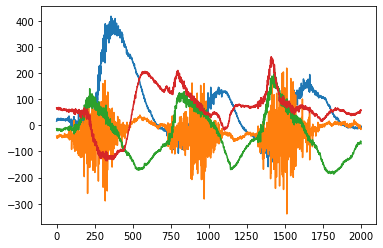

Acurácia: 97.90%
Apresentação do sinal com a aplicação do filtro notch


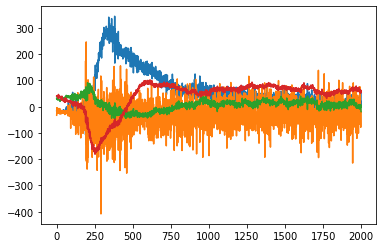

Acurácia: 99.13%
Apresentação do sinal com a aplicação do filtro notch


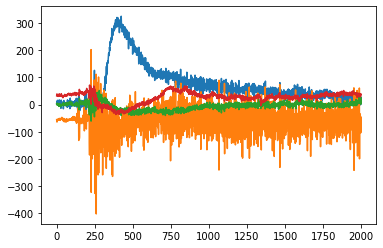

Acurácia: 98.57%
Apresentação do sinal com a aplicação do filtro notch


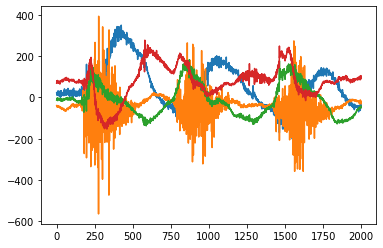

Acurácia: 96.74%
Apresentação do sinal com a aplicação do filtro notch


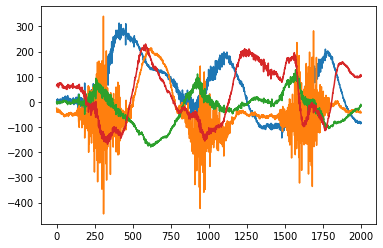

Acurácia: 96.77%
Apresentação do sinal com a aplicação do filtro notch


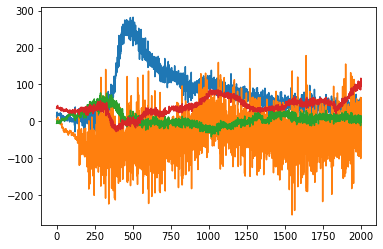

Acurácia: 98.70%

 notch10x
Acurácia: 97.90%
Acurácia: 99.13%
Acurácia: 98.57%
Acurácia: 96.74%
Acurácia: 96.77%
Acurácia: 98.70%

 bandpass


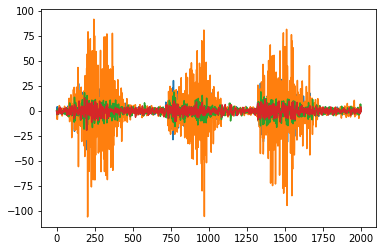

Acurácia: 81.45%


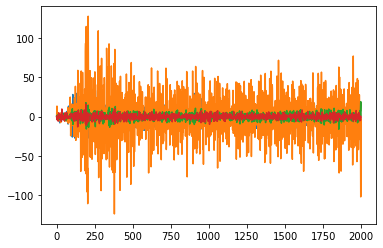

Acurácia: 95.04%


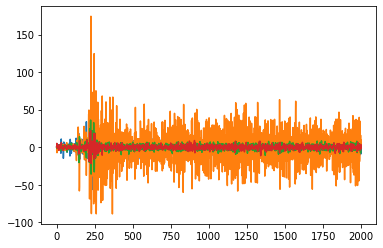

Acurácia: 95.94%


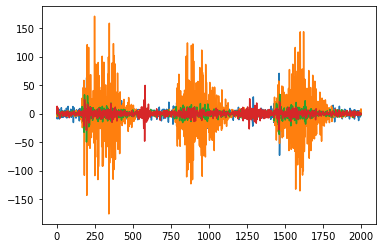

Acurácia: 87.74%


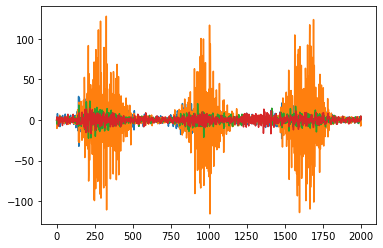

Acurácia: 83.68%


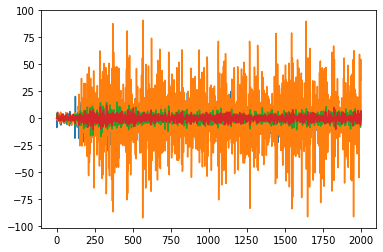

Acurácia: 97.04%

 todos
Acurácia: 81.81%
Acurácia: 95.27%
Acurácia: 96.17%
Acurácia: 88.47%
Acurácia: 84.41%
Acurácia: 97.14%

 todos10x
Acurácia: 76.12%
Acurácia: 91.31%
Acurácia: 93.67%
Acurácia: 80.71%
Acurácia: 78.71%
Acurácia: 95.17%


In [27]:
for filtro in QUAIS_FILTROS:
    print('\n', filtro)
    for arquivo in arquivos:
        x = np.load(path + '/' + arquivo)
        x = np.transpose(x, (0, 2, 1))

        x = aplica_filtros(x)

        w = t_dominio_do_tempo(x)

        #caracteristicas dominio da frequencia
        # FMD
        fmd = np.sum(PSD(w), axis=-1) / 2
        # print(fmd.shape)
        # MMDF
        mmdf = np.sum(np.abs(w), axis=-1) / 2
        # print(mmdf.shape)

        X, y = vetores_de_caracteristicas(fmd, mmdf)
        
        treinamento_e_classificação(X, y)